# <b> <center style="background-color:DodgerBlue;"> DL Assignment 1-Group 299 </center> </b>

### Question No.2. 

Dataset:  data2_1.0_5.csv Download data2_1.0_5.csv

 

Load the attached csv file in python. Each row consists of feature 1, feature 2, class label.
 

Train two single/double hidden layer deep networks by varying the number of hidden nodes (4, 8, 12, 16) in each layer with 70% training and 30% validation data. Use appropriate learning rate, activation, and loss functions and also mention the reason for choosing the same. Report, compare, and explain the observed accuracy and minimum loss achieved. [0.5+1 mark]
 

Visually observe the dataset and design an appropriate feature transformation (derived feature) such that after feature transformation, the dataset can be classified using a minimal network architecture (minimum number of parameters). Design, train this minimal network, and report training and validation errors, and trained parameters of the network. Use 70% training and 30% validation data, appropriate learning rate, activation and loss functions. Explain the final results. [1+1+0.5 marks]
 

Evaluation Process -

Task Response and Task Completion- All the models should be logically sound and have decent accuracy (models with random guessing, frozen and incorrect accuracy, exploding gradients etc. will lead to deduction of marks. Please do a sanity check of your model and results before submission).
There are a lot of subparts, so answer each completely and correctly, as no partial marks will be awarded for partially correct subparts.
Implementation- The model layers, parameters, hyperparameters, evaluation metrics etc. should be properly implemented.
Only fully connected or dense layers are allowed. CNNs/RNNs are strictly not allowed.
Notebooks without output will not be considered for evaluation.
Additional Tips -

Code organization- Please organize your code with correct line spacing and indentation, and add comments to make your code more readable.
Try to give explanations or cite references wherever required.
Use other combinations of hyperparameters to improve model accuracy.


#### -*- coding: utf-8 -*-
#### Indentation: Jupyter Notebook

__version__='1.0.0'
__author__="Sourav Raj, Nitin Agarwal, Anusha linda kostka j e"
__email__="2020sc04304@wilp.bits-pilani.ac.in; 2020sc04557@wilp.bits-pilani.ac.in; 2020sc04900@wilp.bits-pilani.ac.in"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ANN
import keras 
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping


In [2]:
random.seed(42)         # Initialize the random number generator.
np.random.seed(42)      # With the seed reset, the same set of 
                        # numbers will appear every time. 
#tf.set_random_seed(42)  # sets the graph-level random seed
tf.random.set_seed(42)

### Import data

In [3]:
data=pd.read_csv('data2_1.0_5.csv')
data.columns=['feature1', 'feature2', 'class']
print(data.shape)
data.head(2)

(498, 3)


,feature1,feature2,class
0,0.224371,0.028460,0
1,0.284088,0.054416,0


### Data Exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  498 non-null    float64
 1   feature2  498 non-null    float64
 2   class     498 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [5]:
data.describe()

,feature1,feature2,class
count,498.000000,4.980000e+02,498.000000
mean,-0.000528,1.270753e-02,0.502008
std,6.477553,6.400034e+00,0.500499
min,-15.807963,-1.407123e+01,0.000000
25%,-3.930364,-4.177892e+00,0.000000
50%,0.023080,5.804950e-13,1.000000
75%,4.001632,4.114817e+00,1.000000
max,15.607963,1.427091e+01,1.000000


In [6]:
data.isnull().sum()

feature1    0
feature2    0
class       0
dtype: int64

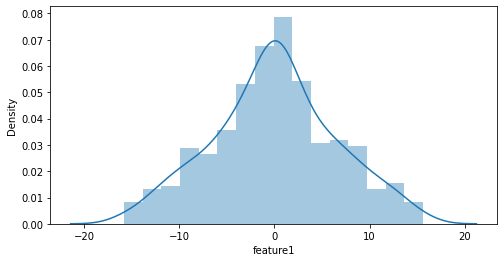

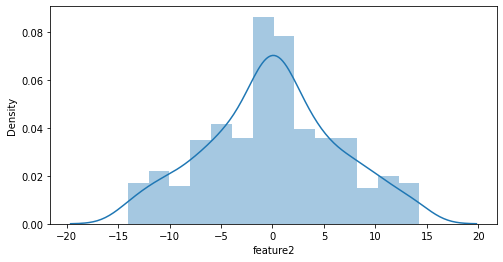

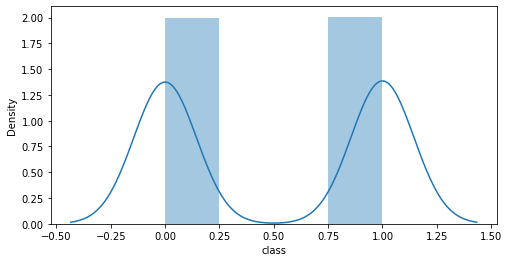

In [7]:
for col in ['feature1', 'feature2', 'class']:
    fig, ax = plt.subplots(1,1, figsize=(8, 4))
    sns.distplot(data[col])

<AxesSubplot:xlabel='feature1', ylabel='feature2'>

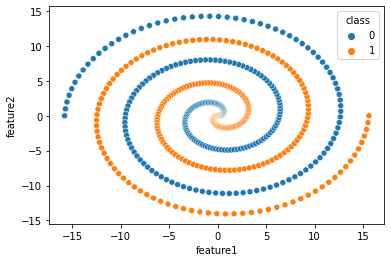

In [8]:
sns.scatterplot(x='feature1', y='feature2', hue='class', data=data)

<AxesSubplot:xlabel='class', ylabel='feature1'>

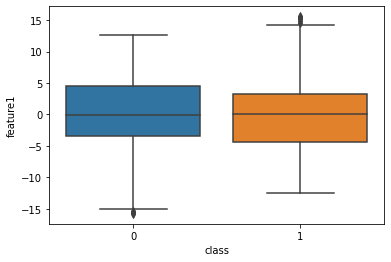

In [9]:
sns.boxplot(x='class', y='feature1', data=data)

<AxesSubplot:xlabel='class', ylabel='feature2'>

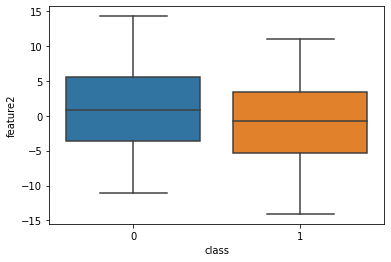

In [10]:
sns.boxplot(x='class', y='feature2', data=data)

## Data Preprocessing

Splitting the data into two parts 70% for training and 30% for validation

In [11]:
Predictor=data.loc[:,['feature1', 'feature2']].values
Target=data.loc[:,'class'].values

X_train, X_test, y_train, y_test = train_test_split(Predictor, Target, test_size=0.3, random_state=42, stratify=Target)

sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Model Building and Evaluation

<b> learning rate: </b> The range of values to consider for the learning rate should be between 10^-6 to 1. A traditional default value for the learning rate is 0.1 or 0.01 which is a good starting point for any problem and this can be further optimize with Hyper parameter tuning. In this problem after several iteration & testing we are taking 0.001 as starting point as its convergence is faster. 

<b> Activation function: </b> As this problem is binary classification problem, we choose sigmoid in the output layer and relu in the hidden layer as its performance is better and doesn't have exploding/vanishing gradient problem. In addition we can also choose hidden layer activation function using hyper parameter tuning.

<b> loss function: </b> Binary crossentropy is used as a loss function for this problem as we have binary class at the target variable.

<b> optimizer: </b> Adam optimizer is used which generally prefer over others.

In addition variable learning rate with factor of 0.5 is used if val_loss is not improving for 10 consecutive patience. 

Early Stopping criteria is used if val_loss is not improving for 50 patience. 

Dropout layer of 0.1 is also added to avoid overfitting in the model

In [12]:
def create_single_hidden_layer_ann_model(input_dim:int, node_in_hidden_layer:int, \
                                         checkpoint_enable:bool=False, checkpoint_dir:str=''):

    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(input_dim, input_dim = input_dim, activation='relu'))
    NN_model.add(Dropout(rate=0.1))
    # The Hidden Layer :
    NN_model.add(Dense(node_in_hidden_layer,activation='relu'))
    NN_model.add(Dropout(rate=0.1))
    # The Output Layer :
    NN_model.add(Dense(1, activation='sigmoid'))
    
    print(NN_model.summary())
    adam=Adam(learning_rate=0.001)
#     sgd=SGD(lr=0.001, momentum=0.9)
    # Compile the network :
    NN_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Define a checkpoint
    if checkpoint_enable:
        checkpoint_name = checkpoint_dir+'/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
        checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
        callbacks_list = [checkpoint]
    else: callbacks_list =None
    return NN_model, callbacks_list
    

### Model building with Single Hidden Layer

Model is created with each node from the given list (4,8,12,16) in single hidden layer 

>>>>>>>>>>>>>>>>>>>> Model training with single layer and 4 node>>>>>>>>>>>>>>>>



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_24 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_25 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
65/70 [===============

Epoch 26/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.4985
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
68/70 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5129
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==============================] - 1s 7ms/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 29/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6931 - accuracy: 0.5046
Epoch 00029: val_loss did not improve from 0.69315
70/70 [==================

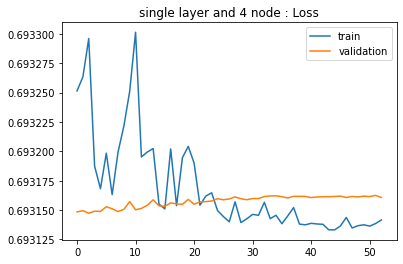

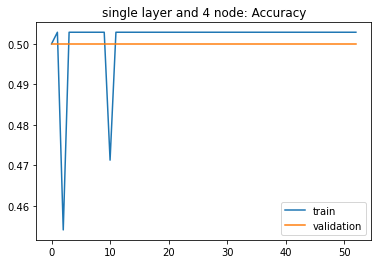

>>>>>>>>>>>>>>>>>>>> Model training with single layer and 8 node>>>>>>>>>>>>>>>>



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_26 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_27 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
60/70 [===============

66/70 [===========================>..] - ETA: 0s - loss: 0.6895 - accuracy: 0.5515
Epoch 00023: val_loss improved from 0.68676 to 0.68639, saving model to tmp\Weights-023--0.68639.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6879 - accuracy: 0.5575 - val_loss: 0.6864 - val_accuracy: 0.4867
Epoch 24/200
61/70 [=========================>....] - ETA: 0s - loss: 0.7031 - accuracy: 0.4721
Epoch 00024: val_loss did not improve from 0.68639
70/70 [==============================] - 1s 8ms/step - loss: 0.7031 - accuracy: 0.4914 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 25/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6945 - accuracy: 0.5226
Epoch 00025: val_loss did not improve from 0.68639
70/70 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.5259 - val_loss: 0.6872 - val_accuracy: 0.5133
Epoch 26/200
68/70 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5294
Epoch 00026: val_loss did not improve 

Epoch 00051: val_loss did not improve from 0.68312
70/70 [==============================] - 1s 8ms/step - loss: 0.6896 - accuracy: 0.5115 - val_loss: 0.6842 - val_accuracy: 0.5067
Epoch 52/200
63/70 [==========================>...] - ETA: 0s - loss: 0.6883 - accuracy: 0.4984
Epoch 00052: val_loss did not improve from 0.68312
70/70 [==============================] - 1s 8ms/step - loss: 0.6861 - accuracy: 0.5086 - val_loss: 0.6844 - val_accuracy: 0.5133
Epoch 53/200
68/70 [============================>.] - ETA: 0s - loss: 0.6874 - accuracy: 0.5441
Epoch 00053: val_loss improved from 0.68312 to 0.68305, saving model to tmp\Weights-053--0.68305.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 0.6875 - accuracy: 0.5460 - val_loss: 0.6831 - val_accuracy: 0.4867
Epoch 54/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6909 - accuracy: 0.4938
Epoch 00054: val_loss did not improve from 0.68305
70/70 [==============================] - 1s 7ms/step - loss: 0.6900 - 

Epoch 80/200
70/70 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5201
Epoch 00080: val_loss did not improve from 0.68302
70/70 [==============================] - 1s 9ms/step - loss: 0.6851 - accuracy: 0.5201 - val_loss: 0.6842 - val_accuracy: 0.4933
Epoch 81/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6887 - accuracy: 0.5303
Epoch 00081: val_loss did not improve from 0.68302
70/70 [==============================] - 1s 10ms/step - loss: 0.6884 - accuracy: 0.5374 - val_loss: 0.6842 - val_accuracy: 0.5000
Epoch 82/200
68/70 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5412
Epoch 00082: val_loss did not improve from 0.68302
70/70 [==============================] - 1s 9ms/step - loss: 0.6844 - accuracy: 0.5431 - val_loss: 0.6839 - val_accuracy: 0.4800
Epoch 83/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6857 - accuracy: 0.5344
Epoch 00083: val_loss did not improve from 0.68302
70/70 [=================

64/70 [==========================>...] - ETA: 0s - loss: 0.6806 - accuracy: 0.5500
Epoch 00109: val_loss did not improve from 0.68302

Epoch 00109: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
70/70 [==============================] - 1s 8ms/step - loss: 0.6824 - accuracy: 0.5460 - val_loss: 0.6840 - val_accuracy: 0.4733
Epoch 00109: early stopping
Final training loss for single layer and 8 node: 0.6823639869689941
Final training accuracy for single layer and 8 node 0.545976996421814
Final validation loss for single layer and 8 node 0.6840155124664307
Final validation accuracy for single layer and 8 node 0.47333332896232605


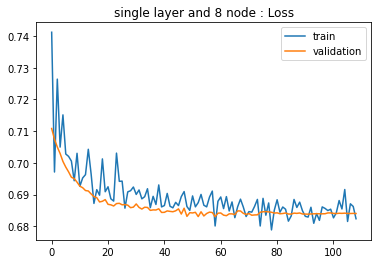

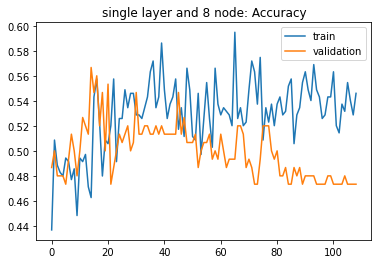

>>>>>>>>>>>>>>>>>>>> Model training with single layer and 12 node>>>>>>>>>>>>>>>>



Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_28 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 12)                36        
_________________________________________________________________
dropout_29 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 13        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
68/70 [==============

Epoch 24/200
68/70 [============================>.] - ETA: 0s - loss: 0.6904 - accuracy: 0.5088
Epoch 00024: val_loss improved from 0.68777 to 0.68758, saving model to tmp\Weights-024--0.68758.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6900 - accuracy: 0.5115 - val_loss: 0.6876 - val_accuracy: 0.5933
Epoch 25/200
70/70 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5402
Epoch 00025: val_loss improved from 0.68758 to 0.68748, saving model to tmp\Weights-025--0.68748.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.6913 - accuracy: 0.5402 - val_loss: 0.6875 - val_accuracy: 0.5267
Epoch 26/200
69/70 [============================>.] - ETA: 0s - loss: 0.6910 - accuracy: 0.4986
Epoch 00026: val_loss improved from 0.68748 to 0.68748, saving model to tmp\Weights-026--0.68748.hdf5
70/70 [==============================] - 1s 9ms/step - loss: 0.6910 - accuracy: 0.5000 - val_loss: 0.6875 - val_accuracy: 0.5867
Epoch 27/200
69/70 

Epoch 51/200
63/70 [==========================>...] - ETA: 0s - loss: 0.6878 - accuracy: 0.5429
Epoch 00051: val_loss did not improve from 0.68319
70/70 [==============================] - 1s 8ms/step - loss: 0.6876 - accuracy: 0.5517 - val_loss: 0.6832 - val_accuracy: 0.6267
Epoch 52/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6895 - accuracy: 0.5281
Epoch 00052: val_loss did not improve from 0.68319
70/70 [==============================] - 1s 9ms/step - loss: 0.6894 - accuracy: 0.5316 - val_loss: 0.6833 - val_accuracy: 0.5533
Epoch 53/200
68/70 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5618
Epoch 00053: val_loss improved from 0.68319 to 0.68277, saving model to tmp\Weights-053--0.68277.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 0.6880 - accuracy: 0.5603 - val_loss: 0.6828 - val_accuracy: 0.6067
Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5086
Epoch 00054: val_loss di

65/70 [==========================>...] - ETA: 0s - loss: 0.6867 - accuracy: 0.5569
Epoch 00079: val_loss did not improve from 0.68018
70/70 [==============================] - 1s 7ms/step - loss: 0.6855 - accuracy: 0.5632 - val_loss: 0.6809 - val_accuracy: 0.5467
Epoch 80/200
63/70 [==========================>...] - ETA: 0s - loss: 0.6872 - accuracy: 0.5778
Epoch 00080: val_loss did not improve from 0.68018
70/70 [==============================] - 1s 7ms/step - loss: 0.6852 - accuracy: 0.5833 - val_loss: 0.6807 - val_accuracy: 0.5467
Epoch 81/200
63/70 [==========================>...] - ETA: 0s - loss: 0.6830 - accuracy: 0.5587
Epoch 00081: val_loss did not improve from 0.68018
70/70 [==============================] - 1s 7ms/step - loss: 0.6852 - accuracy: 0.5546 - val_loss: 0.6805 - val_accuracy: 0.5533
Epoch 82/200
70/70 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.5718
Epoch 00082: val_loss did not improve from 0.68018
70/70 [==============================]

Epoch 108/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6848 - accuracy: 0.5785
Epoch 00108: val_loss did not improve from 0.67945

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
70/70 [==============================] - 1s 9ms/step - loss: 0.6836 - accuracy: 0.5862 - val_loss: 0.6810 - val_accuracy: 0.5400
Epoch 109/200
70/70 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5603
Epoch 00109: val_loss did not improve from 0.67945
70/70 [==============================] - 1s 9ms/step - loss: 0.6857 - accuracy: 0.5603 - val_loss: 0.6810 - val_accuracy: 0.5400
Epoch 110/200
70/70 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.6149
Epoch 00110: val_loss did not improve from 0.67945
70/70 [==============================] - 1s 9ms/step - loss: 0.6772 - accuracy: 0.6149 - val_loss: 0.6806 - val_accuracy: 0.5400
Epoch 111/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6826 - accuracy

Epoch 137/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6798 - accuracy: 0.5970
Epoch 00137: val_loss did not improve from 0.67945
70/70 [==============================] - 1s 11ms/step - loss: 0.6814 - accuracy: 0.5948 - val_loss: 0.6806 - val_accuracy: 0.5400
Epoch 138/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6783 - accuracy: 0.5750
Epoch 00138: val_loss did not improve from 0.67945

Epoch 00138: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
70/70 [==============================] - 1s 11ms/step - loss: 0.6768 - accuracy: 0.5891 - val_loss: 0.6806 - val_accuracy: 0.5400
Epoch 139/200
70/70 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.5862
Epoch 00139: val_loss did not improve from 0.67945
70/70 [==============================] - 1s 9ms/step - loss: 0.6789 - accuracy: 0.5862 - val_loss: 0.6806 - val_accuracy: 0.5400
Epoch 140/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6911 - accura

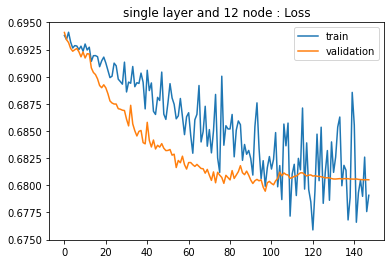

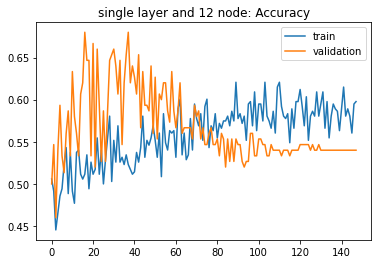

>>>>>>>>>>>>>>>>>>>> Model training with single layer and 16 node>>>>>>>>>>>>>>>>



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_30 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_46 (Dense)             (None, 16)                48        
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 17        
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
66/70 [==============

Epoch 23/200
48/70 [===================>..........] - ETA: 0s - loss: 0.6892 - accuracy: 0.5500
Epoch 00023: val_loss improved from 0.69071 to 0.69049, saving model to tmp\Weights-023--0.69049.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5144 - val_loss: 0.6905 - val_accuracy: 0.5467
Epoch 24/200
52/70 [=====================>........] - ETA: 0s - loss: 0.6915 - accuracy: 0.5192
Epoch 00024: val_loss improved from 0.69049 to 0.69035, saving model to tmp\Weights-024--0.69035.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5431 - val_loss: 0.6904 - val_accuracy: 0.5533
Epoch 25/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6914 - accuracy: 0.5276
Epoch 00025: val_loss improved from 0.69035 to 0.69022, saving model to tmp\Weights-025--0.69022.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6902 - val_accuracy: 0.5533
Epoch 26/200
58/70 

Epoch 50/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6850 - accuracy: 0.5714
Epoch 00050: val_loss improved from 0.68746 to 0.68741, saving model to tmp\Weights-050--0.68741.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5431 - val_loss: 0.6874 - val_accuracy: 0.5467
Epoch 51/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6915 - accuracy: 0.5267
Epoch 00051: val_loss did not improve from 0.68741
70/70 [==============================] - 0s 2ms/step - loss: 0.6898 - accuracy: 0.5374 - val_loss: 0.6876 - val_accuracy: 0.5467
Epoch 52/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6885 - accuracy: 0.5508
Epoch 00052: val_loss did not improve from 0.68741
70/70 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5316 - val_loss: 0.6875 - val_accuracy: 0.5467
Epoch 53/200
52/70 [=====================>........] - ETA: 0s - loss: 0.6894 - accuracy: 0.5192
Epoch 00053: val_loss imp

Epoch 78/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6885 - accuracy: 0.5254
Epoch 00078: val_loss did not improve from 0.68507
70/70 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5460 - val_loss: 0.6852 - val_accuracy: 0.5533
Epoch 79/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6889 - accuracy: 0.5333
Epoch 00079: val_loss improved from 0.68507 to 0.68501, saving model to tmp\Weights-079--0.68501.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6873 - accuracy: 0.5431 - val_loss: 0.6850 - val_accuracy: 0.5533
Epoch 80/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6854 - accuracy: 0.5387
Epoch 00080: val_loss improved from 0.68501 to 0.68486, saving model to tmp\Weights-080--0.68486.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5374 - val_loss: 0.6849 - val_accuracy: 0.5533
Epoch 81/200
58/70 [=======================>......] - ETA: 0s - loss: 

53/70 [=====================>........] - ETA: 0s - loss: 0.6820 - accuracy: 0.5623
Epoch 00106: val_loss did not improve from 0.68394
70/70 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5345 - val_loss: 0.6841 - val_accuracy: 0.5467
Epoch 107/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6860 - accuracy: 0.5443
Epoch 00107: val_loss did not improve from 0.68394
70/70 [==============================] - 0s 2ms/step - loss: 0.6876 - accuracy: 0.5402 - val_loss: 0.6841 - val_accuracy: 0.5467
Epoch 108/200
69/70 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.5304
Epoch 00108: val_loss did not improve from 0.68394
70/70 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5316 - val_loss: 0.6843 - val_accuracy: 0.5467
Epoch 109/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6821 - accuracy: 0.5548
Epoch 00109: val_loss improved from 0.68394 to 0.68380, saving model to tmp\Weights-10

Epoch 135/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5407
Epoch 00135: val_loss did not improve from 0.68354
70/70 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5431 - val_loss: 0.6836 - val_accuracy: 0.5467
Epoch 136/200
51/70 [====================>.........] - ETA: 0s - loss: 0.6841 - accuracy: 0.5294
Epoch 00136: val_loss improved from 0.68354 to 0.68353, saving model to tmp\Weights-136--0.68353.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5374 - val_loss: 0.6835 - val_accuracy: 0.5467
Epoch 137/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6865 - accuracy: 0.5600
Epoch 00137: val_loss did not improve from 0.68353
70/70 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5345 - val_loss: 0.6836 - val_accuracy: 0.5467
Epoch 138/200
68/70 [============================>.] - ETA: 0s - loss: 0.6876 - accuracy: 0.5353
Epoch 00138: val_loss

Epoch 164/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6860 - accuracy: 0.5407
Epoch 00164: val_loss did not improve from 0.68353
70/70 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5402 - val_loss: 0.6836 - val_accuracy: 0.5467
Epoch 165/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6829 - accuracy: 0.5544
Epoch 00165: val_loss did not improve from 0.68353
70/70 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5431 - val_loss: 0.6836 - val_accuracy: 0.5467
Epoch 166/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6867 - accuracy: 0.5448
Epoch 00166: val_loss did not improve from 0.68353

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
70/70 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5345 - val_loss: 0.6836 - val_accuracy: 0.5467
Epoch 167/200
46/70 [==================>...........] - ETA: 0s - loss: 0.6824 - accurac

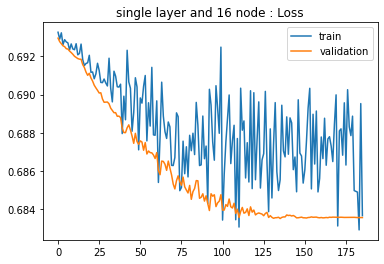

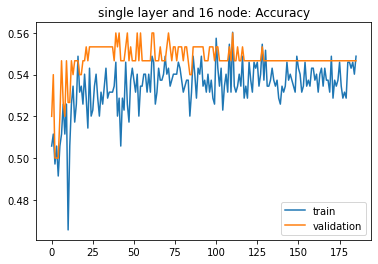

In [20]:
node_list=[4, 8, 12, 16]
Evaluation_summary=pd.DataFrame()
for node in node_list:
    print(f'>>>>>>>>>>>>>>>>>>>> Model training with single layer and {node} node>>>>>>>>>>>>>>>>')
    print('\n\n')
    model, callbacks_list=create_single_hidden_layer_ann_model(input_dim=2, node_in_hidden_layer=node, checkpoint_enable=True, checkpoint_dir='tmp/')
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_delta=1E-7, verbose=1)
    callbacks_list=callbacks_list+[rlrp]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    callbacks_list=callbacks_list+[es]
    model = model.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_test, y_test), callbacks=callbacks_list)
    print(f"Final training loss for single layer and {node} node: {model.history['loss'][-1]}")
    print(f"Final training accuracy for single layer and {node} node {model.history['accuracy'][-1]}")
    print(f"Final validation loss for single layer and {node} node {model.history['val_loss'][-1]}")
    print(f"Final validation accuracy for single layer and {node} node {model.history['val_accuracy'][-1]}")
    Evaluation_summary=Evaluation_summary.append(pd.DataFrame({'NumOfHiddenLayer':[1], 'NumOfNode':[node], \
                'Train Loss':[model.history['loss'][-1]], 'Train Accuracy': [model.history['accuracy'][-1]], \
                    'Validation Loss':[model.history['val_loss'][-1]], 'Validation Accuracy': [model.history['val_accuracy'][-1]]}), ignore_index=True)
    
    plt.title(f'single layer and {node} node : Loss')
    plt.plot(model.history['loss'], label='train')
    plt.plot(model.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    plt.title(f'single layer and {node} node: Accuracy')
    plt.plot(model.history['accuracy'], label='train')
    plt.plot(model.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show()

In [ ]:
plt.title(f'double layer and {node} node : Loss')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.title(f'double layer and {node} node: Accuracy')
plt.plot(model.history['accuracy'], label='train')
plt.plot(model.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

#### Summary of Results for single hidden layer

In [21]:
Evaluation_summary

,NumOfHiddenLayer,NumOfNode,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,4,0.693142,0.502874,0.693161,0.500000
1,1,8,0.682364,0.545977,0.684016,0.473333
2,1,12,0.679079,0.597701,0.680508,0.540000
3,1,16,0.683676,0.548851,0.683576,0.546667


### Model building with double Hidden Layer

Model is created with all permutation from the given list (4,8,12,16) in double hidden layer. so there will be 16 model.


In [22]:
def create_double_hidden_layer_ann_model(input_dim:int, nodes_in_hidden_layers:int, \
                                         checkpoint_enable:bool=False, checkpoint_dir:str=''):

    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(input_dim, input_dim = input_dim, activation='relu'))
    NN_model.add(Dropout(rate=0.1))
    # The Hidden Layer :
    # Layer 1
    NN_model.add(Dense(nodes_in_hidden_layers[0], activation='relu'))
    NN_model.add(Dropout(rate=0.1))
    #Layer 2
    NN_model.add(Dense(nodes_in_hidden_layers[1], activation='relu'))
    NN_model.add(Dropout(rate=0.1))
    # The Output Layer :
    NN_model.add(Dense(1, activation='sigmoid'))
    
    print(NN_model.summary())
    adam=Adam(learning_rate=0.001)
#     adam=SGD(lr=0.001, momentum=0.9)
    # Compile the network :
    NN_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Define a checkpoint
    if checkpoint_enable:
        checkpoint_name = checkpoint_dir+'/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
        checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
        callbacks_list = [checkpoint]
    else: callbacks_list =None
    return NN_model, callbacks_list
    

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [4, 4] node>>>>>>>>>>>>>>>>



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_32 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_33 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 20        
_________________________________________________________________
dropout_34 (Dropout)         (None, 4)                 0         
_______________________

50/70 [====================>.........] - ETA: 0s - loss: 0.6842 - accuracy: 0.5920
Epoch 00023: val_loss improved from 0.68677 to 0.68638, saving model to tmp\Weights-023--0.68638.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5805 - val_loss: 0.6864 - val_accuracy: 0.5333
Epoch 24/200
68/70 [============================>.] - ETA: 0s - loss: 0.6902 - accuracy: 0.5147
Epoch 00024: val_loss improved from 0.68638 to 0.68589, saving model to tmp\Weights-024--0.68589.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5172 - val_loss: 0.6859 - val_accuracy: 0.5400
Epoch 25/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6908 - accuracy: 0.5312
Epoch 00025: val_loss did not improve from 0.68589
70/70 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5402 - val_loss: 0.6861 - val_accuracy: 0.5400
Epoch 26/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6874 - accu

60/70 [========================>.....] - ETA: 0s - loss: 0.6936 - accuracy: 0.5133
Epoch 00051: val_loss did not improve from 0.68375
70/70 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5144 - val_loss: 0.6851 - val_accuracy: 0.5333
Epoch 52/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6883 - accuracy: 0.5200
Epoch 00052: val_loss did not improve from 0.68375
70/70 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5172 - val_loss: 0.6849 - val_accuracy: 0.5333
Epoch 53/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6898 - accuracy: 0.5344
Epoch 00053: val_loss did not improve from 0.68375
70/70 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5287 - val_loss: 0.6844 - val_accuracy: 0.5333
Epoch 54/200
69/70 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5449
Epoch 00054: val_loss did not improve from 0.68375
70/70 [==============================]

Epoch 80/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6912 - accuracy: 0.5280
Epoch 00080: val_loss did not improve from 0.68331
70/70 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5345 - val_loss: 0.6838 - val_accuracy: 0.5333
Epoch 81/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6815 - accuracy: 0.5640
Epoch 00081: val_loss did not improve from 0.68331
70/70 [==============================] - 0s 3ms/step - loss: 0.6877 - accuracy: 0.5489 - val_loss: 0.6836 - val_accuracy: 0.5333
Epoch 82/200
46/70 [==================>...........] - ETA: 0s - loss: 0.6872 - accuracy: 0.5348
Epoch 00082: val_loss did not improve from 0.68331
70/70 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5287 - val_loss: 0.6835 - val_accuracy: 0.5333
Epoch 83/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6870 - accuracy: 0.5520
Epoch 00083: val_loss did not improve from 0.68331
70/70 [==================

Epoch 109/200
49/70 [====================>.........] - ETA: 0s - loss: 0.6902 - accuracy: 0.5265
Epoch 00109: val_loss did not improve from 0.68296
70/70 [==============================] - 0s 3ms/step - loss: 0.6884 - accuracy: 0.5374 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 110/200
49/70 [====================>.........] - ETA: 0s - loss: 0.6897 - accuracy: 0.5184
Epoch 00110: val_loss did not improve from 0.68296
70/70 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5345 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 111/200
48/70 [===================>..........] - ETA: 0s - loss: 0.6920 - accuracy: 0.5250
Epoch 00111: val_loss did not improve from 0.68296
70/70 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5374 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 112/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6842 - accuracy: 0.5811
Epoch 00112: val_loss did not improve from 0.68296
70/70 [==============

Epoch 138/200
49/70 [====================>.........] - ETA: 0s - loss: 0.6956 - accuracy: 0.4939
Epoch 00138: val_loss did not improve from 0.68296

Epoch 00138: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
70/70 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5230 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 139/200
51/70 [====================>.........] - ETA: 0s - loss: 0.6905 - accuracy: 0.5098
Epoch 00139: val_loss did not improve from 0.68296
70/70 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5287 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 140/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5280
Epoch 00140: val_loss did not improve from 0.68296
70/70 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.5517 - val_loss: 0.6834 - val_accuracy: 0.5333
Epoch 141/200
49/70 [====================>.........] - ETA: 0s - loss: 0.6846 - accuracy

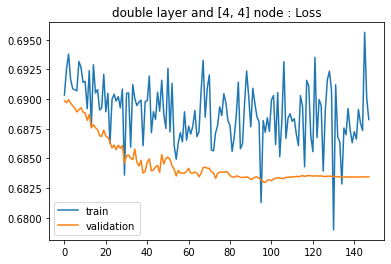

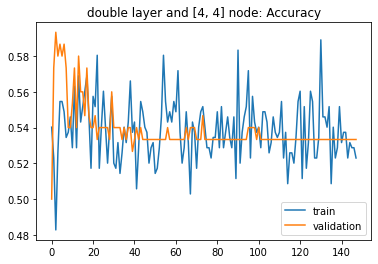

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [4, 4] node>>>>>>>>>>>>>>>>



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_35 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_36 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_37 (Dropout)         (None, 8)                 0         
_______________________

Epoch 25/200
47/70 [===================>..........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5234
Epoch 00025: val_loss did not improve from 0.69240
70/70 [==============================] - 0s 3ms/step - loss: 0.6926 - accuracy: 0.5259 - val_loss: 0.6926 - val_accuracy: 0.5067
Epoch 26/200
52/70 [=====================>........] - ETA: 0s - loss: 0.6937 - accuracy: 0.4538
Epoch 00026: val_loss did not improve from 0.69240
70/70 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.4598 - val_loss: 0.6925 - val_accuracy: 0.4933
Epoch 27/200
48/70 [===================>..........] - ETA: 0s - loss: 0.6922 - accuracy: 0.5208
Epoch 00027: val_loss improved from 0.69240 to 0.69235, saving model to tmp\Weights-027--0.69235.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5086 - val_loss: 0.6924 - val_accuracy: 0.5067
Epoch 28/200
70/70 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5029
Epoch 00028: val_loss imp

Epoch 52/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6888 - accuracy: 0.5480
Epoch 00052: val_loss improved from 0.68940 to 0.68940, saving model to tmp\Weights-052--0.68940.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5374 - val_loss: 0.6894 - val_accuracy: 0.5867
Epoch 53/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6890 - accuracy: 0.4920
Epoch 00053: val_loss improved from 0.68940 to 0.68904, saving model to tmp\Weights-053--0.68904.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.5057 - val_loss: 0.6890 - val_accuracy: 0.5200
Epoch 54/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6890 - accuracy: 0.5406
Epoch 00054: val_loss did not improve from 0.68904
70/70 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5489 - val_loss: 0.6892 - val_accuracy: 0.5867
Epoch 55/200
50/70 [====================>.........] - ETA: 0s - loss: 

48/70 [===================>..........] - ETA: 0s - loss: 0.6829 - accuracy: 0.6125
Epoch 00079: val_loss improved from 0.68688 to 0.68617, saving model to tmp\Weights-079--0.68617.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.6034 - val_loss: 0.6862 - val_accuracy: 0.5067
Epoch 80/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6881 - accuracy: 0.5429
Epoch 00080: val_loss did not improve from 0.68617
70/70 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.5402 - val_loss: 0.6868 - val_accuracy: 0.5867
Epoch 81/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6820 - accuracy: 0.5786
Epoch 00081: val_loss did not improve from 0.68617
70/70 [==============================] - 0s 3ms/step - loss: 0.6860 - accuracy: 0.5603 - val_loss: 0.6864 - val_accuracy: 0.5533
Epoch 82/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6864 - accuracy: 0.5455
Epoch 00082: val_loss did not improve 

69/70 [============================>.] - ETA: 0s - loss: 0.6888 - accuracy: 0.5246
Epoch 00107: val_loss did not improve from 0.68397
70/70 [==============================] - 0s 3ms/step - loss: 0.6879 - accuracy: 0.5259 - val_loss: 0.6846 - val_accuracy: 0.5400
Epoch 108/200
45/70 [==================>...........] - ETA: 0s - loss: 0.6795 - accuracy: 0.6000
Epoch 00108: val_loss did not improve from 0.68397
70/70 [==============================] - 0s 3ms/step - loss: 0.6835 - accuracy: 0.5690 - val_loss: 0.6845 - val_accuracy: 0.5800
Epoch 109/200
48/70 [===================>..........] - ETA: 0s - loss: 0.6861 - accuracy: 0.5417
Epoch 00109: val_loss did not improve from 0.68397
70/70 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5517 - val_loss: 0.6841 - val_accuracy: 0.5400
Epoch 110/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6839 - accuracy: 0.5519
Epoch 00110: val_loss improved from 0.68397 to 0.68371, saving model to tmp\Weights-11

Epoch 136/200
48/70 [===================>..........] - ETA: 0s - loss: 0.6793 - accuracy: 0.5833
Epoch 00136: val_loss did not improve from 0.68258

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
70/70 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5632 - val_loss: 0.6826 - val_accuracy: 0.5200
Epoch 137/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6808 - accuracy: 0.5782
Epoch 00137: val_loss improved from 0.68258 to 0.68256, saving model to tmp\Weights-137--0.68256.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6830 - accuracy: 0.5632 - val_loss: 0.6826 - val_accuracy: 0.5400
Epoch 138/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6832 - accuracy: 0.5520
Epoch 00138: val_loss improved from 0.68256 to 0.68224, saving model to tmp\Weights-138--0.68224.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6791 - accuracy: 0.5805 - val_loss: 0.6822 - val_acc

67/70 [===========================>..] - ETA: 0s - loss: 0.6828 - accuracy: 0.5701
Epoch 00164: val_loss did not improve from 0.68180
70/70 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5718 - val_loss: 0.6819 - val_accuracy: 0.5133
Epoch 165/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6753 - accuracy: 0.5887
Epoch 00165: val_loss did not improve from 0.68180

Epoch 00165: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
70/70 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5977 - val_loss: 0.6818 - val_accuracy: 0.5133
Epoch 166/200
51/70 [====================>.........] - ETA: 0s - loss: 0.6789 - accuracy: 0.6078
Epoch 00166: val_loss improved from 0.68180 to 0.68179, saving model to tmp\Weights-166--0.68179.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 0.6806 - accuracy: 0.5833 - val_loss: 0.6818 - val_accuracy: 0.5133
Epoch 167/200
49/70 [====================>.........]

Epoch 192/200
70/70 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5747
Epoch 00192: val_loss did not improve from 0.68157
70/70 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5747 - val_loss: 0.6816 - val_accuracy: 0.5133
Epoch 193/200
68/70 [============================>.] - ETA: 0s - loss: 0.6803 - accuracy: 0.5647
Epoch 00193: val_loss did not improve from 0.68157
70/70 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.5690 - val_loss: 0.6816 - val_accuracy: 0.5133
Epoch 194/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6840 - accuracy: 0.5815
Epoch 00194: val_loss improved from 0.68157 to 0.68156, saving model to tmp\Weights-194--0.68156.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5690 - val_loss: 0.6816 - val_accuracy: 0.5133
Epoch 195/200
69/70 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5507
Epoch 00195: val_loss

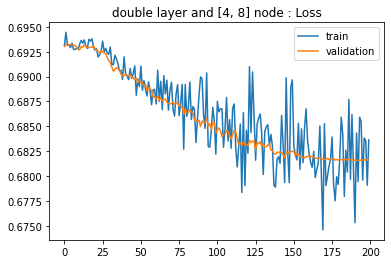

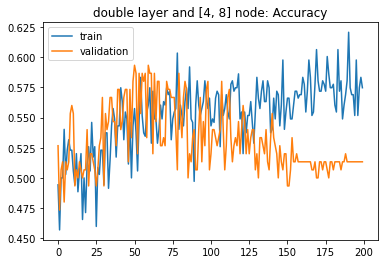

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [4, 8] node>>>>>>>>>>>>>>>>



Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_38 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_39 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 12)                60        
_________________________________________________________________
dropout_40 (Dropout)         (None, 12)                0         
_______________________

Epoch 24/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4893
Epoch 00024: val_loss improved from 0.69439 to 0.69411, saving model to tmp\Weights-024--0.69411.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4971 - val_loss: 0.6941 - val_accuracy: 0.5067
Epoch 25/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6934 - accuracy: 0.5055
Epoch 00025: val_loss did not improve from 0.69411
70/70 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 26/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5200
Epoch 00026: val_loss did not improve from 0.69411
70/70 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5201 - val_loss: 0.6944 - val_accuracy: 0.4600
Epoch 27/200
69/70 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.4928
Epoch 00027: val_loss did

Epoch 53/200
69/70 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5101
Epoch 00053: val_loss did not improve from 0.69411
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5086 - val_loss: 0.6942 - val_accuracy: 0.4867
Epoch 54/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6933 - accuracy: 0.4875
Epoch 00054: val_loss did not improve from 0.69411

Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.4914 - val_loss: 0.6942 - val_accuracy: 0.5267
Epoch 55/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6925 - accuracy: 0.4943
Epoch 00055: val_loss did not improve from 0.69411
70/70 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.4914 - val_loss: 0.6942 - val_accuracy: 0.5267
Epoch 56/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6918 - accuracy: 0.

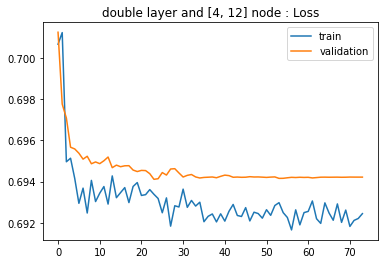

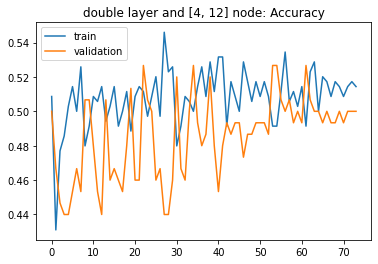

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [4, 12] node>>>>>>>>>>>>>>>>



Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_41 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 12        
_________________________________________________________________
dropout_42 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 16)                80        
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
______________________

Epoch 25/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5055
Epoch 00025: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 26/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6932 - accuracy: 0.4943
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6932 - accuracy: 0.4983
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
52/70 [=====================>........] - ETA: 0s - loss: 0.6929 - accuracy: 0.5269
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==================

Epoch 00053: early stopping
Final training loss for double layer and [4, 16] nodes: 0.693141520023346
Final training accuracy for double layer and [4, 16] nodes 0.5028735399246216
Final validation loss for double layer and [4, 16] nodes 0.6931608319282532
Final validation accuracy for double layer and [4, 16] nodes 0.5


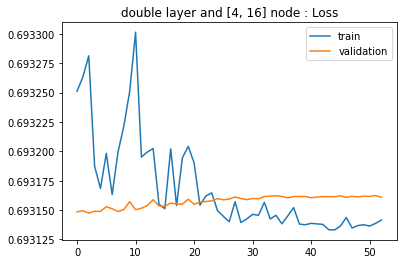

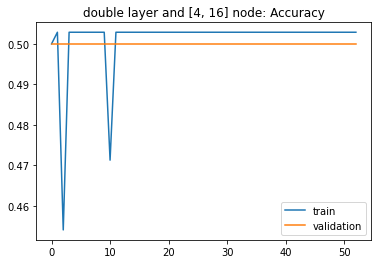

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [4, 16] node>>>>>>>>>>>>>>>>



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_44 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_45 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_46 (Dropout)         (None, 4)                 0         
______________________


Epoch 00001: val_loss improved from inf to 0.69497, saving model to tmp\Weights-001--0.69497.hdf5
70/70 [==============================] - 0s 6ms/step - loss: 0.6985 - accuracy: 0.4684 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5029
Epoch 00002: val_loss improved from 0.69497 to 0.69427, saving model to tmp\Weights-002--0.69427.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5029 - val_loss: 0.6943 - val_accuracy: 0.4400
Epoch 3/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6943 - accuracy: 0.5322
Epoch 00003: val_loss improved from 0.69427 to 0.69407, saving model to tmp\Weights-003--0.69407.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5115 - val_loss: 0.6941 - val_accuracy: 0.4400
Epoch 4/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6944 - accuracy: 0.5167
Epoch 00004: val_loss imp

Epoch 29/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6922 - accuracy: 0.5049
Epoch 00029: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 30/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6940 - accuracy: 0.4759
Epoch 00030: val_loss improved from 0.69315 to 0.69315, saving model to tmp\Weights-030--0.69315.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.4741 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 31/200
70/70 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.4741
Epoch 00031: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4741 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 32/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.5000
Epoch 00032: val_loss did

Epoch 58/200
68/70 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5029
Epoch 00058: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 59/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5069
Epoch 00059: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 60/200
68/70 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5000
Epoch 00060: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 61/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5185
Epoch 00061: val_loss did not improve from 0.69315
70/70 [==================

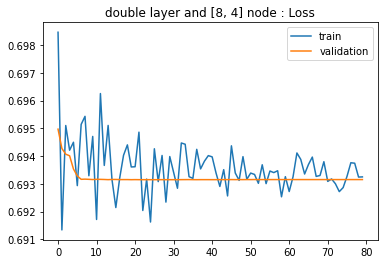

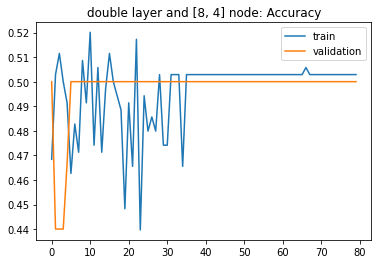

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [8, 4] node>>>>>>>>>>>>>>>>



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_47 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_49 (Dropout)         (None, 8)                 0         
_______________________

55/70 [======================>.......] - ETA: 0s - loss: 0.6908 - accuracy: 0.5273
Epoch 00022: val_loss improved from 0.68828 to 0.68818, saving model to tmp\Weights-022--0.68818.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5230 - val_loss: 0.6882 - val_accuracy: 0.5600
Epoch 23/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5379
Epoch 00023: val_loss improved from 0.68818 to 0.68811, saving model to tmp\Weights-023--0.68811.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5402 - val_loss: 0.6881 - val_accuracy: 0.5667
Epoch 24/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6918 - accuracy: 0.5288
Epoch 00024: val_loss improved from 0.68811 to 0.68796, saving model to tmp\Weights-024--0.68796.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5345 - val_loss: 0.6880 - val_accuracy: 0.5600
Epoch 25/200
60/70 [============

Epoch 49/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6895 - accuracy: 0.5407
Epoch 00049: val_loss did not improve from 0.68515
70/70 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5431 - val_loss: 0.6857 - val_accuracy: 0.5800
Epoch 50/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6905 - accuracy: 0.5536
Epoch 00050: val_loss did not improve from 0.68515
70/70 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5632 - val_loss: 0.6858 - val_accuracy: 0.5733
Epoch 51/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6893 - accuracy: 0.5660
Epoch 00051: val_loss did not improve from 0.68515
70/70 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5603 - val_loss: 0.6854 - val_accuracy: 0.5733
Epoch 52/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6942 - accuracy: 0.5382
Epoch 00052: val_loss did not improve from 0.68515
70/70 [==================

Epoch 78/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6884 - accuracy: 0.5639
Epoch 00078: val_loss improved from 0.68494 to 0.68491, saving model to tmp\Weights-078--0.68491.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5690 - val_loss: 0.6849 - val_accuracy: 0.5800
Epoch 79/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6940 - accuracy: 0.5167
Epoch 00079: val_loss did not improve from 0.68491
70/70 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5316 - val_loss: 0.6850 - val_accuracy: 0.5800
Epoch 80/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6898 - accuracy: 0.5579
Epoch 00080: val_loss did not improve from 0.68491
70/70 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5632 - val_loss: 0.6850 - val_accuracy: 0.5867
Epoch 81/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6891 - accuracy: 0.5407
Epoch 00081: val_loss imp

66/70 [===========================>..] - ETA: 0s - loss: 0.6877 - accuracy: 0.5697
Epoch 00106: val_loss did not improve from 0.68448
70/70 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5632 - val_loss: 0.6849 - val_accuracy: 0.5933
Epoch 107/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6890 - accuracy: 0.5571
Epoch 00107: val_loss did not improve from 0.68448
70/70 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5546 - val_loss: 0.6849 - val_accuracy: 0.5800
Epoch 108/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6859 - accuracy: 0.5745
Epoch 00108: val_loss did not improve from 0.68448

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5575 - val_loss: 0.6849 - val_accuracy: 0.5933
Epoch 109/200
69/70 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.5710
Epoch

Epoch 135/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6864 - accuracy: 0.5759
Epoch 00135: val_loss did not improve from 0.68448
70/70 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5747 - val_loss: 0.6848 - val_accuracy: 0.5933
Epoch 136/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6893 - accuracy: 0.5233
Epoch 00136: val_loss did not improve from 0.68448
70/70 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5402 - val_loss: 0.6848 - val_accuracy: 0.5933
Epoch 137/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6870 - accuracy: 0.5370
Epoch 00137: val_loss did not improve from 0.68448
70/70 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5431 - val_loss: 0.6848 - val_accuracy: 0.5933
Epoch 138/200
70/70 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5489
Epoch 00138: val_loss did not improve from 0.68448

Epoch 00138: ReduceL

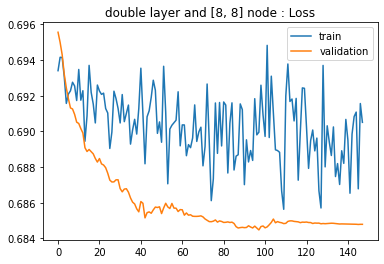

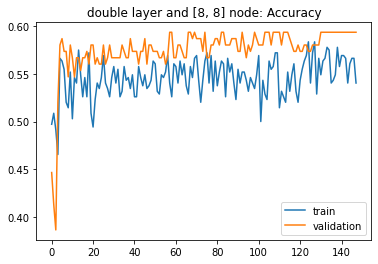

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [8, 8] node>>>>>>>>>>>>>>>>



Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_50 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_51 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 12)                108       
_________________________________________________________________
dropout_52 (Dropout)         (None, 12)                0         
_______________________

Epoch 23/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6936 - accuracy: 0.5185
Epoch 00023: val_loss did not improve from 0.68993
70/70 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5287 - val_loss: 0.6899 - val_accuracy: 0.5467
Epoch 24/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 00024: val_loss did not improve from 0.68993
70/70 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4971 - val_loss: 0.6899 - val_accuracy: 0.5267
Epoch 25/200
70/70 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5259
Epoch 00025: val_loss improved from 0.68993 to 0.68985, saving model to tmp\Weights-025--0.68985.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5259 - val_loss: 0.6898 - val_accuracy: 0.5133
Epoch 26/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5564
Epoch 00026: val_loss imp

Epoch 51/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6924 - accuracy: 0.5200
Epoch 00051: val_loss did not improve from 0.68730
70/70 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5345 - val_loss: 0.6877 - val_accuracy: 0.5467
Epoch 52/200
70/70 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5632
Epoch 00052: val_loss improved from 0.68730 to 0.68697, saving model to tmp\Weights-052--0.68697.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5632 - val_loss: 0.6870 - val_accuracy: 0.5400
Epoch 53/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5000
Epoch 00053: val_loss improved from 0.68697 to 0.68694, saving model to tmp\Weights-053--0.68694.hdf5
70/70 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4914 - val_loss: 0.6869 - val_accuracy: 0.5533
Epoch 54/200
70/70 [==============================] - ETA: 0s - loss: 

Epoch 79/200
69/70 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.5072
Epoch 00079: val_loss did not improve from 0.68457
70/70 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5086 - val_loss: 0.6873 - val_accuracy: 0.5733
Epoch 80/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6886 - accuracy: 0.5276
Epoch 00080: val_loss did not improve from 0.68457

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
70/70 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5345 - val_loss: 0.6856 - val_accuracy: 0.5600
Epoch 81/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6879 - accuracy: 0.5536
Epoch 00081: val_loss did not improve from 0.68457
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5431 - val_loss: 0.6850 - val_accuracy: 0.5467
Epoch 82/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6875 - accuracy: 0.

61/70 [=========================>....] - ETA: 0s - loss: 0.6850 - accuracy: 0.5541
Epoch 00107: val_loss improved from 0.68295 to 0.68278, saving model to tmp\Weights-107--0.68278.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5460 - val_loss: 0.6828 - val_accuracy: 0.5333
Epoch 108/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6874 - accuracy: 0.5778
Epoch 00108: val_loss did not improve from 0.68278
70/70 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5690 - val_loss: 0.6829 - val_accuracy: 0.5400
Epoch 109/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6883 - accuracy: 0.5407
Epoch 00109: val_loss did not improve from 0.68278
70/70 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5431 - val_loss: 0.6829 - val_accuracy: 0.5400
Epoch 110/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6899 - accuracy: 0.5387
Epoch 00110: val_loss did not impro

Epoch 136/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6842 - accuracy: 0.5736
Epoch 00136: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5718 - val_loss: 0.6827 - val_accuracy: 0.5533
Epoch 137/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6909 - accuracy: 0.5193
Epoch 00137: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5172 - val_loss: 0.6828 - val_accuracy: 0.5600
Epoch 138/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6956 - accuracy: 0.4903
Epoch 00138: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4943 - val_loss: 0.6830 - val_accuracy: 0.5667
Epoch 139/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.5088
Epoch 00139: val_loss did not improve from 0.68246
70/70 [==============

Epoch 165/200
70/70 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5661
Epoch 00165: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5661 - val_loss: 0.6830 - val_accuracy: 0.5600
Epoch 166/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6896 - accuracy: 0.5418
Epoch 00166: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5316 - val_loss: 0.6830 - val_accuracy: 0.5600
Epoch 167/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6850 - accuracy: 0.5464
Epoch 00167: val_loss did not improve from 0.68246
70/70 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5345 - val_loss: 0.6830 - val_accuracy: 0.5600
Epoch 168/200
51/70 [====================>.........] - ETA: 0s - loss: 0.6880 - accuracy: 0.5608
Epoch 00168: val_loss did not improve from 0.68246
70/70 [==============

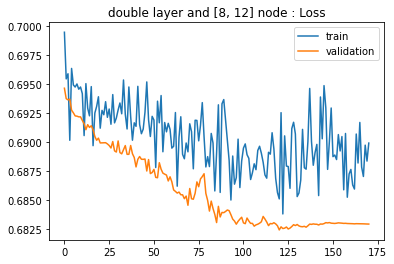

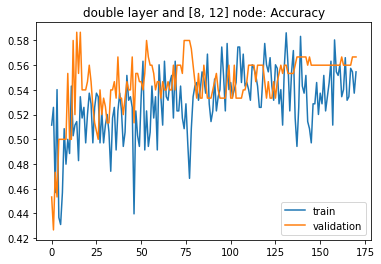

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [8, 12] node>>>>>>>>>>>>>>>>



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_53 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_77 (Dense)             (None, 8)                 24        
_________________________________________________________________
dropout_54 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_55 (Dropout)         (None, 16)                0         
______________________

Epoch 25/200
70/70 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5029
Epoch 00025: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 26/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4963
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5036
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5100
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==================

Epoch 00053: early stopping
Final training loss for double layer and [8, 16] nodes: 0.6931414604187012
Final training accuracy for double layer and [8, 16] nodes 0.5028735399246216
Final validation loss for double layer and [8, 16] nodes 0.6931608319282532
Final validation accuracy for double layer and [8, 16] nodes 0.5


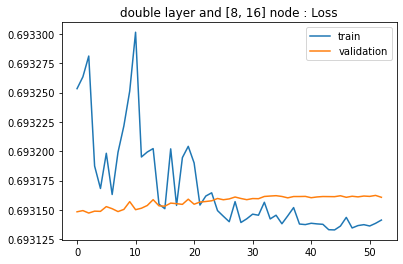

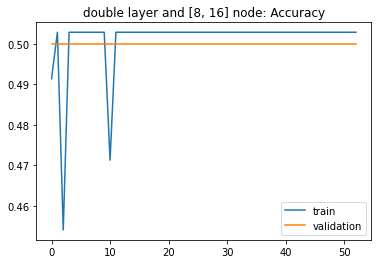

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [8, 16] node>>>>>>>>>>>>>>>>



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_56 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 12)                36        
_________________________________________________________________
dropout_57 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 52        
_________________________________________________________________
dropout_58 (Dropout)         (None, 4)                 0         
______________________

Epoch 25/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5037
Epoch 00025: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 26/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4966
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4966
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5088
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==================

Epoch 54/200
68/70 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5029
Epoch 00054: val_loss did not improve from 0.69310
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 55/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.4985
Epoch 00055: val_loss did not improve from 0.69310

Epoch 00055: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 56/200
69/70 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5072
Epoch 00056: val_loss did not improve from 0.69310
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 57/200
69/70 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5

55/70 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4909
Epoch 00082: val_loss improved from 0.69307 to 0.69307, saving model to tmp\Weights-082--0.69307.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 83/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5018
Epoch 00083: val_loss improved from 0.69307 to 0.69306, saving model to tmp\Weights-083--0.69306.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 84/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6928 - accuracy: 0.5245
Epoch 00084: val_loss did not improve from 0.69306
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 85/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6931 - accu

Epoch 111/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6934 - accuracy: 0.4793
Epoch 00111: val_loss improved from 0.69305 to 0.69305, saving model to tmp\Weights-111--0.69305.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 112/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5036
Epoch 00112: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 113/200
70/70 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5029
Epoch 00113: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 114/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4815
Epoch 00114: val_loss

Epoch 140/200
50/70 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 00140: val_loss improved from 0.69305 to 0.69305, saving model to tmp\Weights-140--0.69305.hdf5
70/70 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 141/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6930 - accuracy: 0.5133
Epoch 00141: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 142/200
69/70 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5043
Epoch 00142: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 143/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6933 - accuracy: 0.4836
Epoch 00143: val_loss

Epoch 168/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5088
Epoch 00168: val_loss improved from 0.69305 to 0.69305, saving model to tmp\Weights-168--0.69305.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 169/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4926
Epoch 00169: val_loss improved from 0.69305 to 0.69305, saving model to tmp\Weights-169--0.69305.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 170/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 00170: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 171/200
57/70 [=======================>......] - ETA: 0s - lo

Epoch 197/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5057
Epoch 00197: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 198/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6932 - accuracy: 0.4915
Epoch 00198: val_loss improved from 0.69305 to 0.69305, saving model to tmp\Weights-198--0.69305.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 199/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6931 - accuracy: 0.4982
Epoch 00199: val_loss did not improve from 0.69305
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 200/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5034
Epoch 00200: val_loss

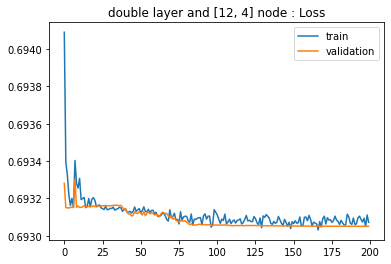

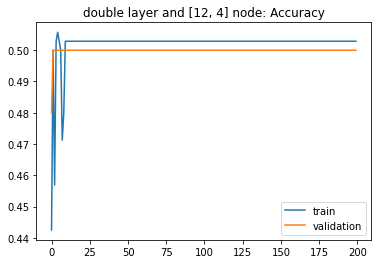

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [12, 4] node>>>>>>>>>>>>>>>>



Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_59 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 12)                36        
_________________________________________________________________
dropout_60 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 8)                 104       
_________________________________________________________________
dropout_61 (Dropout)         (None, 8)                 0         
______________________

Epoch 25/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5107
Epoch 00025: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 26/200
68/70 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5036
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6930 - accuracy: 0.5179
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==================

Epoch 00053: early stopping
Final training loss for double layer and [12, 8] nodes: 0.693141520023346
Final training accuracy for double layer and [12, 8] nodes 0.5028735399246216
Final validation loss for double layer and [12, 8] nodes 0.6931608319282532
Final validation accuracy for double layer and [12, 8] nodes 0.5


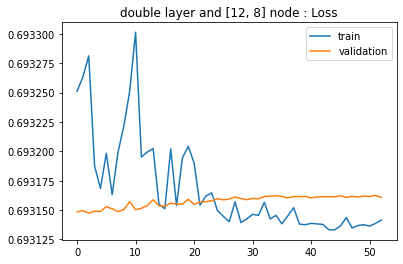

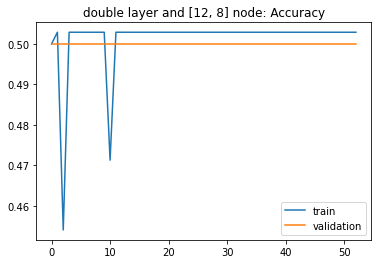

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [12, 8] node>>>>>>>>>>>>>>>>



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_62 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 12)                36        
_________________________________________________________________
dropout_63 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 12)                156       
_________________________________________________________________
dropout_64 (Dropout)         (None, 12)                0         
______________________

65/70 [==========================>...] - ETA: 0s - loss: 0.6912 - accuracy: 0.5231
Epoch 00022: val_loss improved from 0.68908 to 0.68885, saving model to tmp\Weights-022--0.68885.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5115 - val_loss: 0.6889 - val_accuracy: 0.5333
Epoch 23/200
69/70 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.5304
Epoch 00023: val_loss did not improve from 0.68885
70/70 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5316 - val_loss: 0.6890 - val_accuracy: 0.5133
Epoch 24/200
63/70 [==========================>...] - ETA: 0s - loss: 0.6922 - accuracy: 0.5175
Epoch 00024: val_loss improved from 0.68885 to 0.68879, saving model to tmp\Weights-024--0.68879.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5287 - val_loss: 0.6888 - val_accuracy: 0.5133
Epoch 25/200
51/70 [====================>.........] - ETA: 0s - loss: 0.6919 - accu

Epoch 50/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6912 - accuracy: 0.5200
Epoch 00050: val_loss did not improve from 0.68550
70/70 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5144 - val_loss: 0.6870 - val_accuracy: 0.5667
Epoch 51/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5091
Epoch 00051: val_loss did not improve from 0.68550
70/70 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5172 - val_loss: 0.6879 - val_accuracy: 0.5600
Epoch 52/200
62/70 [=========================>....] - ETA: 0s - loss: 0.6904 - accuracy: 0.5129
Epoch 00052: val_loss did not improve from 0.68550
70/70 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5172 - val_loss: 0.6870 - val_accuracy: 0.5600
Epoch 53/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6923 - accuracy: 0.5115
Epoch 00053: val_loss did not improve from 0.68550
70/70 [==================

70/70 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5259 - val_loss: 0.6841 - val_accuracy: 0.5667
Epoch 78/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6913 - accuracy: 0.5283
Epoch 00078: val_loss did not improve from 0.68369
70/70 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5115 - val_loss: 0.6841 - val_accuracy: 0.5400
Epoch 79/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6887 - accuracy: 0.5322
Epoch 00079: val_loss did not improve from 0.68369
70/70 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5374 - val_loss: 0.6843 - val_accuracy: 0.5667
Epoch 80/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6888 - accuracy: 0.5396
Epoch 00080: val_loss did not improve from 0.68369
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5460 - val_loss: 0.6839 - val_accuracy: 0.5400
Epoch 81/200
54/70 [======================>

Epoch 106/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6878 - accuracy: 0.5623
Epoch 00106: val_loss did not improve from 0.68269
70/70 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.5517 - val_loss: 0.6827 - val_accuracy: 0.5467
Epoch 107/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.5224
Epoch 00107: val_loss did not improve from 0.68269
70/70 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5287 - val_loss: 0.6827 - val_accuracy: 0.5533
Epoch 108/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6905 - accuracy: 0.5030
Epoch 00108: val_loss did not improve from 0.68269
70/70 [==============================] - 0s 5ms/step - loss: 0.6902 - accuracy: 0.5115 - val_loss: 0.6828 - val_accuracy: 0.5533
Epoch 109/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6892 - accuracy: 0.5370
Epoch 00109: val_loss improved from 0.68269 to 0.68267, saving model to 

Epoch 135/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6880 - accuracy: 0.5531
Epoch 00135: val_loss improved from 0.68224 to 0.68217, saving model to tmp\Weights-135--0.68217.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6867 - accuracy: 0.5575 - val_loss: 0.6822 - val_accuracy: 0.5333
Epoch 136/200
69/70 [============================>.] - ETA: 0s - loss: 0.6889 - accuracy: 0.5565
Epoch 00136: val_loss improved from 0.68217 to 0.68207, saving model to tmp\Weights-136--0.68207.hdf5
70/70 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.5546 - val_loss: 0.6821 - val_accuracy: 0.5400
Epoch 137/200
61/70 [=========================>....] - ETA: 0s - loss: 0.6856 - accuracy: 0.5639
Epoch 00137: val_loss did not improve from 0.68207
70/70 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5517 - val_loss: 0.6821 - val_accuracy: 0.5333
Epoch 138/200
55/70 [======================>.......] - ETA: 0s - lo

Epoch 164/200
70/70 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5517
Epoch 00164: val_loss did not improve from 0.68207
70/70 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5517 - val_loss: 0.6821 - val_accuracy: 0.5467
Epoch 165/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6906 - accuracy: 0.5424
Epoch 00165: val_loss did not improve from 0.68207
70/70 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5402 - val_loss: 0.6821 - val_accuracy: 0.5467
Epoch 166/200
69/70 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.5449
Epoch 00166: val_loss did not improve from 0.68207

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
70/70 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5402 - val_loss: 0.6822 - val_accuracy: 0.5467
Epoch 167/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6898 - accurac

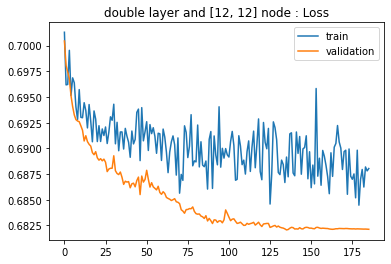

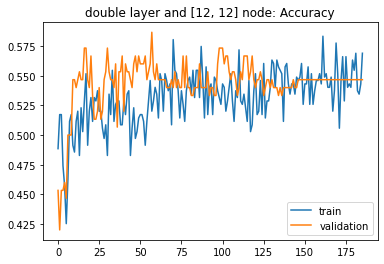

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [12, 12] node>>>>>>>>>>>>>>>>



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_65 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 12)                36        
_________________________________________________________________
dropout_66 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_67 (Dropout)         (None, 16)                0         
_____________________

Epoch 23/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6851 - accuracy: 0.5259
Epoch 00023: val_loss did not improve from 0.68127
70/70 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5144 - val_loss: 0.6827 - val_accuracy: 0.5333
Epoch 24/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6886 - accuracy: 0.5276
Epoch 00024: val_loss did not improve from 0.68127
70/70 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5402 - val_loss: 0.6814 - val_accuracy: 0.5267
Epoch 25/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6883 - accuracy: 0.5418
Epoch 00025: val_loss did not improve from 0.68127
70/70 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5402 - val_loss: 0.6820 - val_accuracy: 0.5333
Epoch 26/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6884 - accuracy: 0.5429
Epoch 00026: val_loss did not improve from 0.68127
70/70 [==================

Epoch 52/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6918 - accuracy: 0.5091
Epoch 00052: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5259 - val_loss: 0.6807 - val_accuracy: 0.5267
Epoch 53/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6891 - accuracy: 0.5321
Epoch 00053: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5575 - val_loss: 0.6798 - val_accuracy: 0.5333
Epoch 54/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6850 - accuracy: 0.5418
Epoch 00054: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5345 - val_loss: 0.6800 - val_accuracy: 0.5333
Epoch 55/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6887 - accuracy: 0.5444
Epoch 00055: val_loss did not improve from 0.67937
70/70 [==================

Epoch 81/200
68/70 [============================>.] - ETA: 0s - loss: 0.6863 - accuracy: 0.5324
Epoch 00081: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.5345 - val_loss: 0.6796 - val_accuracy: 0.5200
Epoch 82/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6843 - accuracy: 0.5250
Epoch 00082: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5259 - val_loss: 0.6796 - val_accuracy: 0.5200
Epoch 83/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6825 - accuracy: 0.5544
Epoch 00083: val_loss did not improve from 0.67937
70/70 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.5546 - val_loss: 0.6796 - val_accuracy: 0.5200
Epoch 84/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6848 - accuracy: 0.5455
Epoch 00084: val_loss did not improve from 0.67937
70/70 [==================

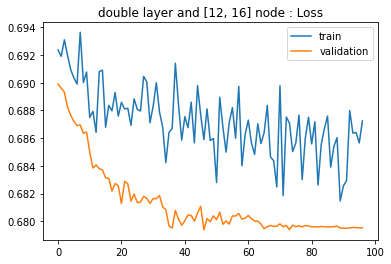

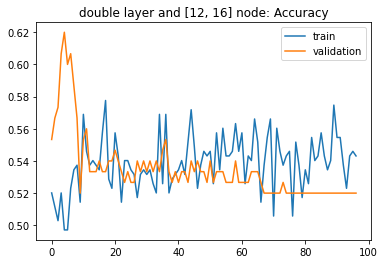

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [12, 16] node>>>>>>>>>>>>>>>>



Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_68 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_97 (Dense)             (None, 16)                48        
_________________________________________________________________
dropout_69 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 68        
_________________________________________________________________
dropout_70 (Dropout)         (None, 4)                 0         
_____________________

Epoch 24/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6933 - accuracy: 0.5143
Epoch 00024: val_loss did not improve from 0.69183
70/70 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5267
Epoch 25/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6941 - accuracy: 0.4963
Epoch 00025: val_loss did not improve from 0.69183
70/70 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5057 - val_loss: 0.6927 - val_accuracy: 0.4867
Epoch 26/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6928 - accuracy: 0.5298
Epoch 00026: val_loss did not improve from 0.69183
70/70 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5144 - val_loss: 0.6926 - val_accuracy: 0.5067
Epoch 27/200
64/70 [==========================>...] - ETA: 0s - loss: 0.6929 - accuracy: 0.4781
Epoch 00027: val_loss did not improve from 0.69183
70/70 [==================

Epoch 53/200
69/70 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5217
Epoch 00053: val_loss did not improve from 0.69174
70/70 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5201 - val_loss: 0.6927 - val_accuracy: 0.5467
Epoch 54/200
69/70 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5362
Epoch 00054: val_loss did not improve from 0.69174
70/70 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5374 - val_loss: 0.6928 - val_accuracy: 0.5667
Epoch 55/200
69/70 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.5391
Epoch 00055: val_loss did not improve from 0.69174
70/70 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5402 - val_loss: 0.6927 - val_accuracy: 0.5267
Epoch 56/200
69/70 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.4986
Epoch 00056: val_loss did not improve from 0.69174
70/70 [==================

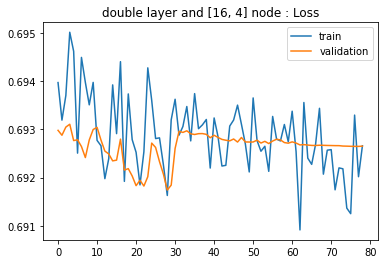

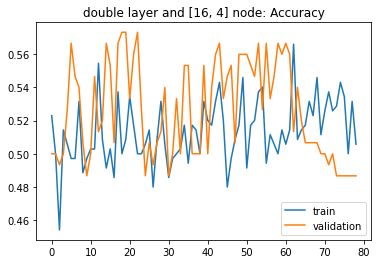

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [16, 4] node>>>>>>>>>>>>>>>>



Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_71 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 16)                48        
_________________________________________________________________
dropout_72 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_73 (Dropout)         (None, 8)                 0         
______________________

Epoch 25/200
70/70 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5029
Epoch 00025: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 26/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4945
Epoch 00026: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 27/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6932 - accuracy: 0.4966
Epoch 00027: val_loss did not improve from 0.69315
70/70 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 28/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6931 - accuracy: 0.5088
Epoch 00028: val_loss did not improve from 0.69315
70/70 [==================

Epoch 00053: early stopping
Final training loss for double layer and [16, 8] nodes: 0.693141520023346
Final training accuracy for double layer and [16, 8] nodes 0.5028735399246216
Final validation loss for double layer and [16, 8] nodes 0.6931608319282532
Final validation accuracy for double layer and [16, 8] nodes 0.5


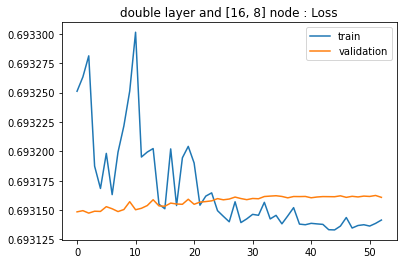

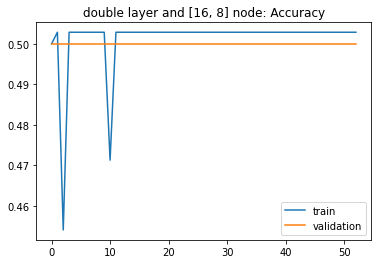

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [16, 8] node>>>>>>>>>>>>>>>>



Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_74 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_105 (Dense)            (None, 16)                48        
_________________________________________________________________
dropout_75 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 12)                204       
_________________________________________________________________
dropout_76 (Dropout)         (None, 12)                0         
______________________

Epoch 23/200
66/70 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.5182
Epoch 00023: val_loss did not improve from 0.68161
70/70 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.5201 - val_loss: 0.6816 - val_accuracy: 0.5867
Epoch 24/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6886 - accuracy: 0.5370
Epoch 00024: val_loss improved from 0.68161 to 0.68118, saving model to tmp\Weights-024--0.68118.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5546 - val_loss: 0.6812 - val_accuracy: 0.5800
Epoch 25/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6903 - accuracy: 0.5356
Epoch 00025: val_loss improved from 0.68118 to 0.67984, saving model to tmp\Weights-025--0.67984.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5374 - val_loss: 0.6798 - val_accuracy: 0.6133
Epoch 26/200
57/70 [=======================>......] - ETA: 0s - loss: 

Epoch 52/200
70/70 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5230
Epoch 00052: val_loss did not improve from 0.67944

Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
70/70 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5230 - val_loss: 0.6817 - val_accuracy: 0.5533
Epoch 53/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6851 - accuracy: 0.5684
Epoch 00053: val_loss did not improve from 0.67944
70/70 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5747 - val_loss: 0.6807 - val_accuracy: 0.5467
Epoch 54/200
59/70 [========================>.....] - ETA: 0s - loss: 0.6914 - accuracy: 0.5254
Epoch 00054: val_loss did not improve from 0.67944
70/70 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5259 - val_loss: 0.6812 - val_accuracy: 0.5400
Epoch 55/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6863 - accuracy: 0.

Epoch 81/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6917 - accuracy: 0.5396
Epoch 00081: val_loss did not improve from 0.67944
70/70 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5460 - val_loss: 0.6806 - val_accuracy: 0.5467
Epoch 82/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6857 - accuracy: 0.5579
Epoch 00082: val_loss did not improve from 0.67944

Epoch 00082: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
70/70 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5546 - val_loss: 0.6806 - val_accuracy: 0.5467
Epoch 00082: early stopping
Final training loss for double layer and [16, 12] nodes: 0.6877560615539551
Final training accuracy for double layer and [16, 12] nodes 0.5545976758003235
Final validation loss for double layer and [16, 12] nodes 0.6805731654167175
Final validation accuracy for double layer and [16, 12] nodes 0.54666668176651


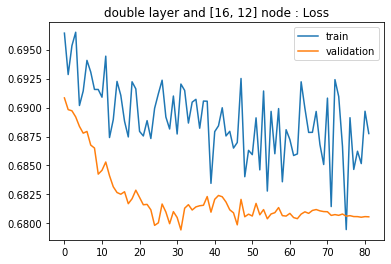

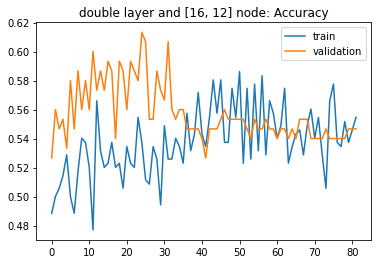

>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and [16, 12] node>>>>>>>>>>>>>>>>



Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 2)                 6         
_________________________________________________________________
dropout_77 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_109 (Dense)            (None, 16)                48        
_________________________________________________________________
dropout_78 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_79 (Dropout)         (None, 16)                0         
_____________________

55/70 [======================>.......] - ETA: 0s - loss: 0.6916 - accuracy: 0.5564
Epoch 00023: val_loss did not improve from 0.68891
70/70 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5431 - val_loss: 0.6890 - val_accuracy: 0.5400
Epoch 24/200
65/70 [==========================>...] - ETA: 0s - loss: 0.6898 - accuracy: 0.5354
Epoch 00024: val_loss improved from 0.68891 to 0.68872, saving model to tmp\Weights-024--0.68872.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5374 - val_loss: 0.6887 - val_accuracy: 0.5667
Epoch 25/200
60/70 [========================>.....] - ETA: 0s - loss: 0.6893 - accuracy: 0.5400
Epoch 00025: val_loss improved from 0.68872 to 0.68805, saving model to tmp\Weights-025--0.68805.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5259 - val_loss: 0.6881 - val_accuracy: 0.5867
Epoch 26/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6942 - accu

57/70 [=======================>......] - ETA: 0s - loss: 0.6865 - accuracy: 0.5754
Epoch 00050: val_loss did not improve from 0.68444
70/70 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5661 - val_loss: 0.6854 - val_accuracy: 0.5600
Epoch 51/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6940 - accuracy: 0.5018
Epoch 00051: val_loss did not improve from 0.68444
70/70 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5029 - val_loss: 0.6857 - val_accuracy: 0.5667
Epoch 52/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6866 - accuracy: 0.5547
Epoch 00052: val_loss did not improve from 0.68444
70/70 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5603 - val_loss: 0.6860 - val_accuracy: 0.5667
Epoch 53/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6923 - accuracy: 0.5185
Epoch 00053: val_loss did not improve from 0.68444
70/70 [==============================]

Epoch 78/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6869 - accuracy: 0.5660
Epoch 00078: val_loss did not improve from 0.68273
70/70 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5431 - val_loss: 0.6835 - val_accuracy: 0.5533
Epoch 79/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6898 - accuracy: 0.5491
Epoch 00079: val_loss did not improve from 0.68273
70/70 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5431 - val_loss: 0.6834 - val_accuracy: 0.5600
Epoch 80/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6855 - accuracy: 0.5655
Epoch 00080: val_loss did not improve from 0.68273
70/70 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.5632 - val_loss: 0.6831 - val_accuracy: 0.5600
Epoch 81/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6856 - accuracy: 0.5673
Epoch 00081: val_loss did not improve from 0.68273
70/70 [==================

54/70 [======================>.......] - ETA: 0s - loss: 0.6914 - accuracy: 0.5259
Epoch 00106: val_loss improved from 0.68213 to 0.68206, saving model to tmp\Weights-106--0.68206.hdf5
70/70 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5345 - val_loss: 0.6821 - val_accuracy: 0.5600
Epoch 107/200
53/70 [=====================>........] - ETA: 0s - loss: 0.6868 - accuracy: 0.5208
Epoch 00107: val_loss did not improve from 0.68206
70/70 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5172 - val_loss: 0.6821 - val_accuracy: 0.5800
Epoch 108/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6935 - accuracy: 0.5179
Epoch 00108: val_loss did not improve from 0.68206
70/70 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5201 - val_loss: 0.6824 - val_accuracy: 0.5733
Epoch 109/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6893 - accuracy: 0.5259
Epoch 00109: val_loss improved from

Epoch 135/200
67/70 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.5433
Epoch 00135: val_loss did not improve from 0.68137
70/70 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5517 - val_loss: 0.6818 - val_accuracy: 0.5667
Epoch 136/200
70/70 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.5575
Epoch 00136: val_loss did not improve from 0.68137

Epoch 00136: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
70/70 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5575 - val_loss: 0.6815 - val_accuracy: 0.5867
Epoch 137/200
52/70 [=====================>........] - ETA: 0s - loss: 0.6855 - accuracy: 0.5731
Epoch 00137: val_loss did not improve from 0.68137
70/70 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5575 - val_loss: 0.6816 - val_accuracy: 0.5667
Epoch 138/200
56/70 [=======================>......] - ETA: 0s - loss: 0.6969 - accuracy

Epoch 164/200
58/70 [=======================>......] - ETA: 0s - loss: 0.6888 - accuracy: 0.5586
Epoch 00164: val_loss did not improve from 0.68134
70/70 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5460 - val_loss: 0.6818 - val_accuracy: 0.5667
Epoch 165/200
57/70 [=======================>......] - ETA: 0s - loss: 0.6891 - accuracy: 0.5509
Epoch 00165: val_loss did not improve from 0.68134
70/70 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5546 - val_loss: 0.6818 - val_accuracy: 0.5667
Epoch 166/200
54/70 [======================>.......] - ETA: 0s - loss: 0.6906 - accuracy: 0.5444
Epoch 00166: val_loss did not improve from 0.68134
70/70 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5259 - val_loss: 0.6819 - val_accuracy: 0.5667
Epoch 167/200
68/70 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5441
Epoch 00167: val_loss did not improve from 0.68134
70/70 [==============

Epoch 193/200
55/70 [======================>.......] - ETA: 0s - loss: 0.6897 - accuracy: 0.5382
Epoch 00193: val_loss did not improve from 0.68134

Epoch 00193: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
70/70 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5489 - val_loss: 0.6818 - val_accuracy: 0.5667
Epoch 00193: early stopping
Final training loss for double layer and [16, 16] nodes: 0.689835786819458
Final training accuracy for double layer and [16, 16] nodes 0.5488505959510803
Final validation loss for double layer and [16, 16] nodes 0.6818221211433411
Final validation accuracy for double layer and [16, 16] nodes 0.5666666626930237


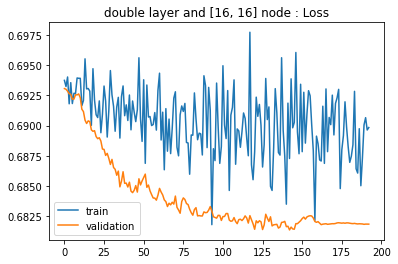

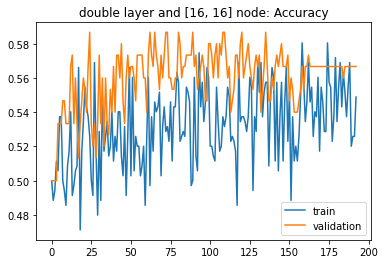

In [25]:
node_list=[4, 8, 12, 16]
Evaluation_summary=pd.DataFrame()
for node1 in node_list:
    for node2 in node_list:
        print(f'>>>>>>>>>>>>>>>>>>>> Model training with double hidden layer and {node} node>>>>>>>>>>>>>>>>')
        print('\n\n')
        node=[node1, node2]
        model, callbacks_list=create_double_hidden_layer_ann_model(input_dim=2, nodes_in_hidden_layers=node, checkpoint_enable=True, checkpoint_dir='tmp/')
        rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_delta=1E-7, verbose=1)
        callbacks_list=callbacks_list+[rlrp]
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
        callbacks_list=callbacks_list+[es]
        model = model.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_test, y_test), callbacks=callbacks_list)
        print(f"Final training loss for double layer and {node} nodes: {model.history['loss'][-1]}")
        print(f"Final training accuracy for double layer and {node} nodes {model.history['accuracy'][-1]}")
        print(f"Final validation loss for double layer and {node} nodes {model.history['val_loss'][-1]}")
        print(f"Final validation accuracy for double layer and {node} nodes {model.history['val_accuracy'][-1]}")
        Evaluation_summary=Evaluation_summary.append(pd.DataFrame({'NumOfHiddenLayer':[2], 'NumOfNode':[node], \
                    'Train Loss':[model.history['loss'][-1]], 'Train Accuracy': [model.history['accuracy'][-1]], \
                        'Validation Loss':[model.history['val_loss'][-1]], 'Validation Accuracy': [model.history['val_accuracy'][-1]]}), ignore_index=True)

        plt.title(f'double layer and {node} node : Loss')
        plt.plot(model.history['loss'], label='train')
        plt.plot(model.history['val_loss'], label='validation')
        plt.legend()
        plt.show()
        plt.title(f'double layer and {node} node: Accuracy')
        plt.plot(model.history['accuracy'], label='train')
        plt.plot(model.history['val_accuracy'], label='validation')
        plt.legend()
        plt.show()

In [ ]:
plt.title(f'double layer and {node} node : Loss')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.title(f'double layer and {node} node: Accuracy')
plt.plot(model.history['accuracy'], label='train')
plt.plot(model.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [26]:
Evaluation_summary

,NumOfHiddenLayer,NumOfNode,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,2,"[4, 4]",0.688271,0.522988,0.683449,0.533333
1,2,"[4, 8]",0.683639,0.574713,0.681645,0.513333
2,2,"[4, 12]",0.692443,0.514368,0.694219,0.500000
3,2,"[4, 16]",0.693142,0.502874,0.693161,0.500000
4,2,"[8, 4]",0.693248,0.502874,0.693151,0.500000
5,2,"[8, 8]",0.690507,0.540230,0.684791,0.593333
6,2,"[8, 12]",0.689918,0.554598,0.682962,0.566667
7,2,"[8, 16]",0.693141,0.502874,0.693161,0.500000
8,2,"[12, 4]",0.693072,0.502874,0.693050,0.500000
9,2,"[12, 8]",0.693142,0.502874,0.693161,0.500000


### Conclusion:

In [ ]:


04 nodes:
With 4 nodes per layer we can see that the validation loss decreases gradaully from 0.6719 to 0.6523. The model accuracy also follows the same pattern with the training dataset.

08 nodes:
With 8 nodes per layer we can see that there is a decrease in the validation loss from 0.6975 to 0.6717. We have high model accuracy as compared with model with 4 nodes in each layer.

12 nodes:
With 12 nodes per layer we can see that there is a decrease in the validation loss from 0.6966 to 0.6792. We have high model accuracy as compared with model with 8 nodes in each layer.

16 nodes:
With 16 nodes per layer we can see that there is a decrease in the validation loss from 0.6966 to 0.6792. We have high model accuracy as compared with model with 8 nodes in each layer.


### Feature transformation

<AxesSubplot:xlabel='feature1', ylabel='feature2'>

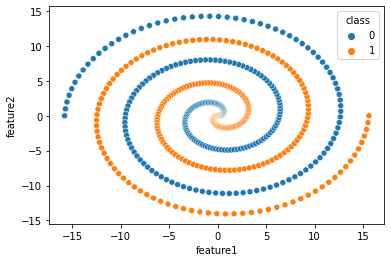

In [27]:
sns.scatterplot(x='feature1', y='feature2', hue='class', data=data)

<AxesSubplot:xlabel='feature_transformed', ylabel='feature1'>

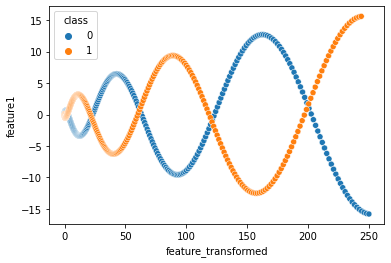

In [33]:
data['feature_transformed']=(data['feature1'])**2 + (data['feature2'])**2
sns.scatterplot(x='feature_transformed', y='feature1', hue='class', data=data)

<AxesSubplot:xlabel='feature_transformed', ylabel='feature2'>

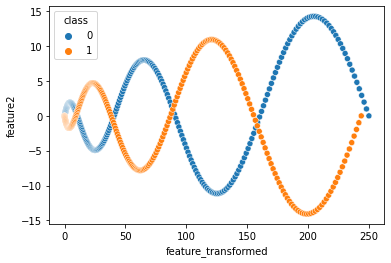

In [34]:
sns.scatterplot(x='feature_transformed', y='feature2', hue='class', data=data)

In [35]:
data[data['feature_transformed'].isnull()].head()

,feature1,feature2,class,feature11,feature_transformed


### Data Preprocessing

Splitting the data into two parts 70% for training and 30% for validation


In [37]:
Predictor=data.loc[:,['feature1', 'feature2', 'feature_transformed']].values
Target=data.loc[:,'class'].values

X_train, X_test, y_train, y_test = train_test_split(Predictor, Target, test_size=0.3, random_state=42, stratify=Target)


Scaling

In [38]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [47]:
print(f'>>>>>>>>>>>>>>>>>>>> Model training with single hidden layer and 8 node >>>>>>>>>>>>>>>>')
print('\n\n')
node=8
Evaluation_summary=pd.DataFrame()
model, callbacks_list=create_single_hidden_layer_ann_model(input_dim=3, node_in_hidden_layer=node, checkpoint_enable=True, checkpoint_dir='tmp/')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_delta=1E-7, verbose=1)
callbacks_list=callbacks_list+[rlrp]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list=callbacks_list+[es]
model = model.fit(X_train, y_train, epochs=500, batch_size=5, validation_data=(X_test, y_test), callbacks=callbacks_list)
print(f"Final training loss for single layer and {node} nodes: {model.history['loss'][-1]}")
print(f"Final training accuracy for single layer and {node} nodes {model.history['accuracy'][-1]}")
print(f"Final validation loss for single layer and {node} nodes {model.history['val_loss'][-1]}")
print(f"Final validation accuracy for single layer and {node} nodes {model.history['val_accuracy'][-1]}")
Evaluation_summary=Evaluation_summary.append(pd.DataFrame({'NumOfHiddenLayer':[1], 'NumOfNode':[node], \
            'Train Loss':[model.history['loss'][-1]], 'Train Accuracy': [model.history['accuracy'][-1]], \
                'Validation Loss':[model.history['val_loss'][-1]], 'Validation Accuracy': [model.history['val_accuracy'][-1]]}), ignore_index=True)



>>>>>>>>>>>>>>>>>>>> Model training with single hidden layer and 8 node >>>>>>>>>>>>>>>>



Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 3)                 12        
_________________________________________________________________
dropout_87 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_124 (Dense)            (None, 8)                 32        
_________________________________________________________________
dropout_88 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 9         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
70/70 [=======

Epoch 23/500
68/70 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.5353
Epoch 00023: val_loss improved from 0.68364 to 0.68330, saving model to tmp\Weights-023--0.68330.hdf5
70/70 [==============================] - 1s 10ms/step - loss: 0.6893 - accuracy: 0.5402 - val_loss: 0.6833 - val_accuracy: 0.6133
Epoch 24/500
67/70 [===========================>..] - ETA: 0s - loss: 0.6845 - accuracy: 0.5731
Epoch 00024: val_loss improved from 0.68330 to 0.68210, saving model to tmp\Weights-024--0.68210.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6838 - accuracy: 0.5833 - val_loss: 0.6821 - val_accuracy: 0.6267
Epoch 25/500
60/70 [========================>.....] - ETA: 0s - loss: 0.6866 - accuracy: 0.5500
Epoch 00025: val_loss improved from 0.68210 to 0.68122, saving model to tmp\Weights-025--0.68122.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6867 - accuracy: 0.5489 - val_loss: 0.6812 - val_accuracy: 0.6400
Epoch 26/500
66/70

70/70 [==============================] - 1s 7ms/step - loss: 0.6788 - accuracy: 0.5489 - val_loss: 0.6668 - val_accuracy: 0.6133
Epoch 49/500
65/70 [==========================>...] - ETA: 0s - loss: 0.6722 - accuracy: 0.6092
Epoch 00049: val_loss improved from 0.66684 to 0.66606, saving model to tmp\Weights-049--0.66606.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.6727 - accuracy: 0.6092 - val_loss: 0.6661 - val_accuracy: 0.6200
Epoch 50/500
68/70 [============================>.] - ETA: 0s - loss: 0.6771 - accuracy: 0.5735
Epoch 00050: val_loss improved from 0.66606 to 0.66584, saving model to tmp\Weights-050--0.66584.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6780 - accuracy: 0.5747 - val_loss: 0.6658 - val_accuracy: 0.6333
Epoch 51/500
66/70 [===========================>..] - ETA: 0s - loss: 0.6753 - accuracy: 0.5697
Epoch 00051: val_loss improved from 0.66584 to 0.66503, saving model to tmp\Weights-051--0.66503.hdf5
70/70 [============

Epoch 75/500
67/70 [===========================>..] - ETA: 0s - loss: 0.6740 - accuracy: 0.5791
Epoch 00075: val_loss did not improve from 0.65521
70/70 [==============================] - 1s 7ms/step - loss: 0.6771 - accuracy: 0.5690 - val_loss: 0.6562 - val_accuracy: 0.6400
Epoch 76/500
65/70 [==========================>...] - ETA: 0s - loss: 0.6724 - accuracy: 0.5692
Epoch 00076: val_loss did not improve from 0.65521
70/70 [==============================] - 1s 7ms/step - loss: 0.6699 - accuracy: 0.5776 - val_loss: 0.6553 - val_accuracy: 0.6400
Epoch 77/500
69/70 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6000
Epoch 00077: val_loss improved from 0.65521 to 0.65498, saving model to tmp\Weights-077--0.65498.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6688 - accuracy: 0.6006 - val_loss: 0.6550 - val_accuracy: 0.6400
Epoch 78/500
70/70 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.5776
Epoch 00078: val_loss imp

Epoch 102/500
68/70 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.5941
Epoch 00102: val_loss improved from 0.64732 to 0.64660, saving model to tmp\Weights-102--0.64660.hdf5
70/70 [==============================] - 1s 8ms/step - loss: 0.6696 - accuracy: 0.5833 - val_loss: 0.6466 - val_accuracy: 0.6333
Epoch 103/500
68/70 [============================>.] - ETA: 0s - loss: 0.6637 - accuracy: 0.5882
Epoch 00103: val_loss did not improve from 0.64660
70/70 [==============================] - 0s 7ms/step - loss: 0.6614 - accuracy: 0.5948 - val_loss: 0.6477 - val_accuracy: 0.6267
Epoch 104/500
62/70 [=========================>....] - ETA: 0s - loss: 0.6590 - accuracy: 0.6097
Epoch 00104: val_loss did not improve from 0.64660
70/70 [==============================] - 1s 8ms/step - loss: 0.6637 - accuracy: 0.6006 - val_loss: 0.6468 - val_accuracy: 0.6267
Epoch 105/500
67/70 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.5881
Epoch 00105: val_loss

Epoch 130/500
70/70 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.5948
Epoch 00130: val_loss improved from 0.64005 to 0.63986, saving model to tmp\Weights-130--0.63986.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.6596 - accuracy: 0.5948 - val_loss: 0.6399 - val_accuracy: 0.6133
Epoch 131/500
67/70 [===========================>..] - ETA: 0s - loss: 0.6628 - accuracy: 0.6000
Epoch 00131: val_loss did not improve from 0.63986
70/70 [==============================] - 0s 6ms/step - loss: 0.6630 - accuracy: 0.5948 - val_loss: 0.6408 - val_accuracy: 0.6133
Epoch 132/500
70/70 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.5776
Epoch 00132: val_loss improved from 0.63986 to 0.63983, saving model to tmp\Weights-132--0.63983.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.6610 - accuracy: 0.5776 - val_loss: 0.6398 - val_accuracy: 0.6067
Epoch 133/500
62/70 [=========================>....] - ETA: 0s - lo

64/70 [==========================>...] - ETA: 0s - loss: 0.6723 - accuracy: 0.5500
Epoch 00158: val_loss did not improve from 0.63511
70/70 [==============================] - 0s 7ms/step - loss: 0.6731 - accuracy: 0.5460 - val_loss: 0.6353 - val_accuracy: 0.6200
Epoch 159/500
64/70 [==========================>...] - ETA: 0s - loss: 0.6590 - accuracy: 0.5656
Epoch 00159: val_loss improved from 0.63511 to 0.63440, saving model to tmp\Weights-159--0.63440.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.6615 - accuracy: 0.5632 - val_loss: 0.6344 - val_accuracy: 0.6200
Epoch 160/500
68/70 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.5765
Epoch 00160: val_loss did not improve from 0.63440
70/70 [==============================] - 0s 7ms/step - loss: 0.6643 - accuracy: 0.5718 - val_loss: 0.6345 - val_accuracy: 0.6200
Epoch 161/500
66/70 [===========================>..] - ETA: 0s - loss: 0.6573 - accuracy: 0.5909
Epoch 00161: val_loss improved from

Epoch 186/500
63/70 [==========================>...] - ETA: 0s - loss: 0.6462 - accuracy: 0.6032
Epoch 00186: val_loss did not improve from 0.63137
70/70 [==============================] - 1s 8ms/step - loss: 0.6513 - accuracy: 0.6034 - val_loss: 0.6326 - val_accuracy: 0.6267
Epoch 187/500
62/70 [=========================>....] - ETA: 0s - loss: 0.6579 - accuracy: 0.6032
Epoch 00187: val_loss did not improve from 0.63137
70/70 [==============================] - 1s 9ms/step - loss: 0.6573 - accuracy: 0.6063 - val_loss: 0.6315 - val_accuracy: 0.6200
Epoch 188/500
63/70 [==========================>...] - ETA: 0s - loss: 0.6645 - accuracy: 0.5429
Epoch 00188: val_loss did not improve from 0.63137
70/70 [==============================] - 1s 9ms/step - loss: 0.6631 - accuracy: 0.5546 - val_loss: 0.6322 - val_accuracy: 0.6267
Epoch 189/500
66/70 [===========================>..] - ETA: 0s - loss: 0.6561 - accuracy: 0.5970
Epoch 00189: val_loss did not improve from 0.63137
70/70 [==============

Epoch 214/500
67/70 [===========================>..] - ETA: 0s - loss: 0.6476 - accuracy: 0.6119
Epoch 00214: val_loss did not improve from 0.62927
70/70 [==============================] - 0s 7ms/step - loss: 0.6479 - accuracy: 0.6121 - val_loss: 0.6294 - val_accuracy: 0.6200
Epoch 215/500
64/70 [==========================>...] - ETA: 0s - loss: 0.6515 - accuracy: 0.6031
Epoch 00215: val_loss did not improve from 0.62927
70/70 [==============================] - 0s 6ms/step - loss: 0.6551 - accuracy: 0.5948 - val_loss: 0.6298 - val_accuracy: 0.6200
Epoch 216/500
68/70 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.5794
Epoch 00216: val_loss did not improve from 0.62927
70/70 [==============================] - 0s 7ms/step - loss: 0.6531 - accuracy: 0.5833 - val_loss: 0.6293 - val_accuracy: 0.6133
Epoch 217/500
64/70 [==========================>...] - ETA: 0s - loss: 0.6560 - accuracy: 0.5813
Epoch 00217: val_loss did not improve from 0.62927
70/70 [==============

69/70 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.5797
Epoch 00242: val_loss did not improve from 0.62826
70/70 [==============================] - 0s 6ms/step - loss: 0.6611 - accuracy: 0.5805 - val_loss: 0.6289 - val_accuracy: 0.6200
Epoch 243/500
63/70 [==========================>...] - ETA: 0s - loss: 0.6433 - accuracy: 0.6349
Epoch 00243: val_loss did not improve from 0.62826
70/70 [==============================] - 0s 6ms/step - loss: 0.6428 - accuracy: 0.6264 - val_loss: 0.6286 - val_accuracy: 0.6200
Epoch 244/500
61/70 [=========================>....] - ETA: 0s - loss: 0.6554 - accuracy: 0.5967
Epoch 00244: val_loss improved from 0.62826 to 0.62812, saving model to tmp\Weights-244--0.62812.hdf5
70/70 [==============================] - 0s 6ms/step - loss: 0.6474 - accuracy: 0.6063 - val_loss: 0.6281 - val_accuracy: 0.6200
Epoch 245/500
60/70 [========================>.....] - ETA: 0s - loss: 0.6516 - accuracy: 0.5900
Epoch 00245: val_loss did not impro

Epoch 270/500
70/70 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.6293
Epoch 00270: val_loss did not improve from 0.62667
70/70 [==============================] - 1s 7ms/step - loss: 0.6454 - accuracy: 0.6293 - val_loss: 0.6267 - val_accuracy: 0.6133
Epoch 271/500
66/70 [===========================>..] - ETA: 0s - loss: 0.6476 - accuracy: 0.5939
Epoch 00271: val_loss did not improve from 0.62667
70/70 [==============================] - 0s 7ms/step - loss: 0.6528 - accuracy: 0.5862 - val_loss: 0.6268 - val_accuracy: 0.6133
Epoch 272/500
70/70 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.6092
Epoch 00272: val_loss did not improve from 0.62667
70/70 [==============================] - 0s 7ms/step - loss: 0.6457 - accuracy: 0.6092 - val_loss: 0.6267 - val_accuracy: 0.6133
Epoch 273/500
70/70 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.5891
Epoch 00273: val_loss improved from 0.62667 to 0.62643, saving model to 

Epoch 299/500
68/70 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6059
Epoch 00299: val_loss did not improve from 0.62643
70/70 [==============================] - 1s 9ms/step - loss: 0.6552 - accuracy: 0.6034 - val_loss: 0.6266 - val_accuracy: 0.6133
Epoch 300/500
62/70 [=========================>....] - ETA: 0s - loss: 0.6552 - accuracy: 0.5903
Epoch 00300: val_loss did not improve from 0.62643
70/70 [==============================] - 1s 8ms/step - loss: 0.6529 - accuracy: 0.5891 - val_loss: 0.6266 - val_accuracy: 0.6133
Epoch 301/500
65/70 [==========================>...] - ETA: 0s - loss: 0.6564 - accuracy: 0.5785
Epoch 00301: val_loss did not improve from 0.62643
70/70 [==============================] - 1s 7ms/step - loss: 0.6620 - accuracy: 0.5690 - val_loss: 0.6266 - val_accuracy: 0.6133
Epoch 302/500
70/70 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6149
Epoch 00302: val_loss did not improve from 0.62643
70/70 [==============

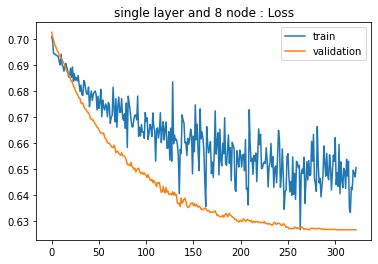

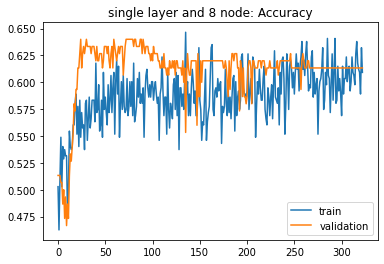

In [48]:
plt.title(f'single layer and {node} node : Loss')
plt.plot(model.history['loss'], label='train')
plt.plot(model.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.title(f'single layer and {node} node: Accuracy')
plt.plot(model.history['accuracy'], label='train')
plt.plot(model.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [49]:
Evaluation_summary

,NumOfHiddenLayer,NumOfNode,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,8,0.650489,0.609195,0.626513,0.613333
